In [1]:
import numpy as np
import rasterio # must be version >1. (using 1.09)
import pandas as pd
import matplotlib.pyplot as plt
import os as os
%matplotlib inline

In [2]:
# bilinear interpolation
def bilint(z,en):
    """
    https://en.wikipedia.org/wiki/Bilinear_interpolation for a unit square
    """
    r = en[1]
    c = en[0]
    ir = np.int(r)
    ic = np.int(c)
    rx = r-ir
    cy = c-ic
    #print(r,ir,rx,'  ',c,ic,cy)
    #print(z[ir,ic],z[ir+1,ic])
    #print(z[ir+1,ic],z[ir+1,ic+1])
    zi = z[ir,ic]*(1.-cy)*(1.-rx)+z[ir+1,ic]*cy*(1.-rx)+z[ir,ic+1]*(1.-cy)*rx+z[ir+1,ic+1]*rx*cy
    return zi


2017-01-09_SandwichTNB
2017-01-09_SandwichTNB_trans.txt  has  839 lines.
Read:  837  lines.
Reading F:\Sandwich\2017-01-09_SandwichTNB_DEM_10cm.tif...
DEM shape:  (21030, 32490)
rasterio gdal version:  2.2.0
CRS({'init': 'epsg:6348'})
| 0.10, 0.00, 376140.00|
| 0.00,-0.10, 4625467.00|
| 0.00, 0.00, 1.00|
upper left:  (376140.0, 4625467.0)
lower right:  (379389.0, 4623364.0)

Statistics for interpolated values:
count    836.000000
mean       0.005268
std        0.087332
min       -1.112043
25%       -0.020284
50%        0.005189
75%        0.033075
max        0.446159
Name: DEM_minus_trans (m), dtype: float64

Saving to F:\Sandwich\dem_trans\2017-01-09_SandwichTNB.txt


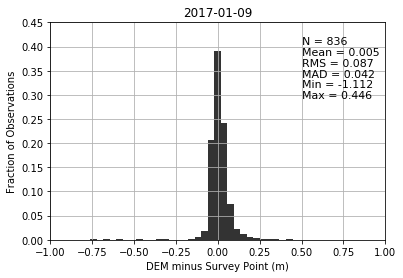

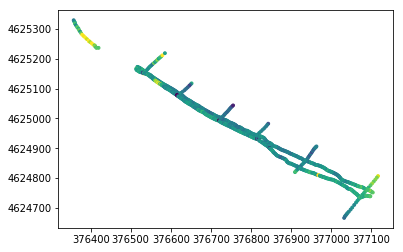

In [56]:
survey_dates = ["2017-01-09"]#,"2017-01-25","2017-02-14","2017-03-16","2017-05-04","2017-09-18"]
indir =  "F:\\Sandwich\\"
outdir = "F:\\Sandwich\\dem_trans\\"

for date in survey_dates:
    bname = date+"_SandwichTNB"
    print(bname)
    dname = bname+"_DEM_10cm.tif"
    tname = bname+"_trans.txt"
    try:
        f=open(indir+tname,'r')
    except OSError:
        print(tname+"is missing.")
    else:
        print(tname," has ",len(f.readlines()),"lines.")
        
    # read in the transect points
    df=pd.read_csv(indir+tname, header = 1, skiprows=0, delimiter=',')
    print("Read: ",len(df.index),' lines.')
    
    # read DEM channel 1
    print("Reading "+indir+dname+"...")
    with rasterio.open(indir+dname) as dem:
        z = dem.read(1)
    print("DEM shape: ",np.shape(z))
    
    # The transform uses rasterio 
    print("rasterio gdal version: ",rasterio.gdal_version())
    # coordinate reference system
    print(dem.crs)
    # data transform
    print(dem.transform)
    # upper left corner
    print('upper left: ',dem.transform*(0,0))
    # lower right corner
    print('lower right: ',dem.transform*(dem.width, dem.height))
    
    # arrays for DEM and differences calcs
    zdem = np.NaN*np.ones(len(df.index))
    zdem_minus_meas = np.NaN*np.ones(len(df.index))
    
    for index, row in df.iterrows():
        en = ~dem.transform*(row["# X/Easting (m)"],row["Y/Northing (m)"])
        #print( index, en )

        # bilinear interpolation in DEM
        try:
            zdem[index]=bilint(z,en)
        except:
            print("interpolation problem")

        # No data values for DEM are -32767
        if(zdem[index]<-32000.):
            zdem[index]=np.NaN           

        zdem_minus_meas[index] = zdem[index]-row["Z/Elevation (m)"]
        #print( zdem[index], zdi[index], row["elev"], zdem_minus_meas[index]  )

    # add columns to the dataframe
    #df.assign(DEM2=pd.Series(zdem,index=df.index))
    df['DEM (interp, m)']=pd.Series(zdem,index=df.index)
    df['DEM_minus_trans (m)']=pd.Series(zdem_minus_meas,index=df.index)
        
    print("\nStatistics for interpolated values:")
    print(df['DEM_minus_trans (m)'].describe())
    
    print("\nSaving to "+outdir+bname+".txt")
    df.to_csv(outdir+bname+'.txt',na_rep='nan',sep=',',float_format='% 12.4f')
    
    ## Histogram of the data
    dz = df['DEM_minus_trans (m)'].as_matrix()
    dz = dz[~np.isnan(dz)]
    dz = dz[np.abs(dz)<5.]

    dzN = len(dz)
    dzMAD = np.mean(np.abs(dz))
    dzmean = dz.mean()
    dzmin = dz.min()
    dzmax = dz.max()
    dzRMS = np.sqrt(np.mean(dz**2))

    fig = plt.figure()
    # next line must be combined with normed=False to get fractional distribution correct
    weights = np.ones_like(dz)/float(len(dz))
    n, bins, patches = plt.hist(dz, bins=40, weights=weights, normed=False, facecolor=(.2,.2,.2), alpha=1)
    xaxmax = 1
    xaxmin = -1
    yaxmin = 0.
    yaxmax = .45

    plt.xlabel('DEM minus Survey Point (m)')
    plt.ylabel('Fraction of Observations')
    plt.title(date)
    plt.axis([xaxmin, xaxmax, yaxmin, yaxmax])
    plt.grid(True)
    plt.text(.75*(xaxmax-xaxmin)+xaxmin,.9*(yaxmax-yaxmin)+yaxmin,'N = {}'.format(dzN), fontsize=11)
    plt.text(.75*(xaxmax-xaxmin)+xaxmin,.85*(yaxmax-yaxmin)+yaxmin,'Mean = {:.3f}'.format(dzmean), fontsize=11)
    plt.text(.75*(xaxmax-xaxmin)+xaxmin,.8*(yaxmax-yaxmin)+yaxmin,'RMS = {:.3f}'.format(dzRMS), fontsize=11)
    plt.text(.75*(xaxmax-xaxmin)+xaxmin,.75*(yaxmax-yaxmin)+yaxmin,'MAD = {:.3f}'.format(dzMAD), fontsize=11)
    plt.text(.75*(xaxmax-xaxmin)+xaxmin,.7 *(yaxmax-yaxmin)+yaxmin,'Min = {:.3f}'.format(dzmin), fontsize=11)
    plt.text(.75*(xaxmax-xaxmin)+xaxmin,.65*(yaxmax-yaxmin)+yaxmin,'Max = {:.3f}'.format(dzmax), fontsize=11)
    plt.show()

    fig_name = outdir+date+"_DEM_minus_transect_HIST.png"
    fig.savefig(fig_name)
    
    # make map of differences
    dz = df['DEM_minus_trans (m)'].as_matrix()
    x = df['# X/Easting (m)'].as_matrix()
    y = df['Y/Northing (m)'].as_matrix()
    fig2 = plt.figure()
    plt.plot(figsize=(12,6))
    #plt.imshow(z[::],cmap=plt.cm.gray,vmin=-2,vmax=13)
    plt.scatter(x,y,8,dz,vmin=-.2,vmax=.2)
    fig_name = outdir+date+"_DEM_minus_transect_MAP.png"
    fig2.savefig(fig_name)

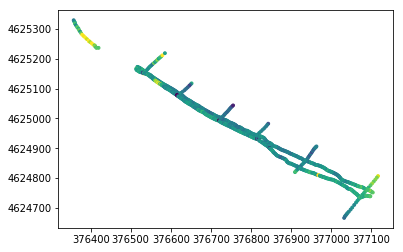

In [51]:
dz = df['DEM_minus_trans'].as_matrix()
x = df['# X/Easting (m)'].as_matrix()
y = df['Y/Northing (m)'].as_matrix()
plt.plot(figsize=(12,6))
#plt.imshow(z[::],cmap=plt.cm.gray,vmin=-2,vmax=13)
plt.scatter(x,y,8,dz,vmin=-.2,vmax=.2)